# 🌆 #30DayMapChallenge - Day 29: Overture Data

**Map for day 29 of the [#30DayMapChallenge](https://30daymapchallenge.com/) 2024, created for Náttúrufræðistofnun.**

| Run the code via free cloud platforms: | [![Binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/lmi/30DayMapChallenge/master?filepath=/Day-29/Day29-Overture.ipynb) | [![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/lmi/30DayMapChallenge/blob/master/Day-29/Day29-Overture.ipynb) | [![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lmi/30DayMapChallenge/blob/master/Day-29/Day29-Overture.ipynb) |
|---|---|---|---|

## Urban Fabric Maps: A Glimpse into City Structures

This map showcases **urban fabric maps** of cities worldwide, created using the **Overture dataset**. An urban fabric map distills the essence of a city by highlighting its layout, structure, and design—capturing roads, buildings, and other key features to offer a minimalist yet powerful visualization of urban life.

These maps focus on the **geometry of cities**, stripping away details to reveal patterns and textures that make each city unique. Inspired by Arthur Dolmajian’s urban fabric maps, this collection highlights the diversity of cities across the globe.

---

### Cities Mapped
The following cities are represented:
- **Reykjavík**  
- **Prague**  
- **Zürich**  
- **Bern**  
- **Paris**  
- **Berlin**  
- **London**  
- **Vienna**  
- **Madrid**  
- **Rome**  
- **Tokyo**  

Each map captures the city’s **urban structure**, offering a comparison of how cities from different parts of the world are laid out and planned.

---

### Data and Design
- **Data Source**: Overture Maps Foundation  
- **Author**: Marco Pizzolato  
- **Tools**: Python, Jupyter Notebook  

---

**License**: Creative Commons **CC BY 4.0**

---

This project brings together cities from around the world into one cohesive collection, illustrating the elegance of urban design through a minimalist lens. Dive into the urban fabric of these cities and explore the unique patterns that define them! 🌍

![Day 29 - Overture](Day29-Overture.png)

## Install and import

In [6]:
!pip install overturemaps


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
# import our toolkit
import pandas as pd
import geopandas as gpd
import duckdb
from shapely import wkt
import matplotlib.pyplot as plt
import os
from shapely.geometry import Point
import math

## Select city centerpoints

In [39]:
# Define city coordinates (longitude, latitude)
city_points = {
    "Reykjavik": (-21.930565, 64.145445,),
    "Prague": (14.422710, 50.090456),
    "Zurich": (8.537803, 47.373047),
    "Bern": (7.4438359, 46.9485139),
    "Paris": (2.3609244, 48.8613860),
    "Berlin": (13.4195298, 52.5009683),
    "London": (-0.1340402, 51.5196086),
    "Vienna": (16.3717066, 48.2101459),
    "Madrid": (-3.7002, 40.4213),
    "Rome": (12.4768194, 41.8985839),
    "Tokio": (139.797308, 35.723685),
}

## Buffer around point

In [ ]:
# Convert city points to GeoDataFrame
gdf = gpd.GeoDataFrame(
    city_points.keys(),
    geometry=[Point(lon, lat) for lon, lat in city_points.values()],
    crs="EPSG:4326"  # WGS84
)

# Reproject to EPSG:3857 for meters
gdf = gdf.to_crs(epsg=3857)

# Create  buffer around each point
BUFFER = 2000 # 2 km buffer. Change this value for other size of data
buffers = gdf.buffer(BUFFER)  # Buffer x meters in all directions

# Convert buffers to bounding boxes
bounding_boxes = {}
for city, buffer in zip(city_points.keys(), buffers):
    # Get bounding box (minx, miny, maxx, maxy)
    minx, miny, maxx, maxy = buffer.bounds
    # Reproject back to WGS84 for final bounding box
    box_gdf = gpd.GeoDataFrame(geometry=[buffer], crs="EPSG:3857").to_crs(epsg=4326)
    minx, miny, maxx, maxy = box_gdf.total_bounds
    # Add to bounding box dictionary
    bounding_boxes[city] = [minx, miny, maxx, maxy]

# Print resulting bounding boxes
for city, bbox in bounding_boxes.items():
    print(f"{city}: {bbox}")

Reykjavik: [-21.94853130568239, 64.13760900141129, -21.91259869431761, 64.1532787877076]
Prague: [14.404743694317608, 50.07892783780017, 14.440676305682391, 50.10198138969465]
Zurich: [8.51983669431761, 47.360878415889125, 8.555769305682391, 47.38521277691159]
Bern: [7.425869594317608, 46.93624770136891, 7.46180220568239, 46.96077728828636]
Paris: [2.3429580943176096, 48.84956487806375, 2.3788907056823905, 48.87320433062765]
Berlin: [13.401563494317609, 52.49002998649503, 13.437496105682389, 52.51190389265383]
London: [-0.15200650568239044, 51.508427752262655, -0.11607389431760956, 51.530786703509705]
Vienna: [16.353740294317607, 48.19817174616576, 16.389672905682392, 48.222117254642626]
Madrid: [-3.71816630568239, 40.40762090931645, -3.6822336943176093, 40.43497630972693]
Rome: [12.458853094317611, 41.88520967453196, 12.494785705682391, 41.911955325101104]
Tokio: [139.7793416943176, 35.7090978591252, 139.81527430568238, 35.738269470404]


## Download the geojson from Overture Data

In [41]:
import subprocess

# Loop through each city and run the overturemaps download command
for city, bbox in bounding_boxes.items():
    # Format the bounding box into a string
    bbox_str = f"{bbox[0]},{bbox[1]},{bbox[2]},{bbox[3]}"
    # Output file name
    output_file = f"{city.lower()}_buildings.geojson"
    # Overturemaps command
    command = f"overturemaps download --bbox={bbox_str} -f geojson --type=building -o {output_file}"
    
    try:
        # Run the command
        subprocess.run(command, shell=True, check=True)
        print(f"Downloaded buildings for {city} into {output_file}")
    except subprocess.CalledProcessError as e:
        print(f"Failed to download buildings for {city}: {e}")

Downloaded buildings for Reykjavik into reykjavik_buildings.geojson
Downloaded buildings for Prague into prague_buildings.geojson
Downloaded buildings for Zurich into zurich_buildings.geojson
Downloaded buildings for Bern into bern_buildings.geojson
Downloaded buildings for Paris into paris_buildings.geojson
Downloaded buildings for Berlin into berlin_buildings.geojson
Downloaded buildings for London into london_buildings.geojson
Downloaded buildings for Vienna into vienna_buildings.geojson
Downloaded buildings for Madrid into madrid_buildings.geojson
Downloaded buildings for Rome into rome_buildings.geojson
Downloaded buildings for Tokio into tokio_buildings.geojson


## To Download an additional city

In [ ]:
# Download single city
import subprocess
output_file = f"prague_buildings.geojson"
bbox = bounding_boxes["Prague"]
bbox_str = f"{bbox[0]},{bbox[1]},{bbox[2]},{bbox[3]}"
command = f"overturemaps download --bbox={bbox_str} -f geojson --type=building -o {output_file}"
subprocess.run(command, shell=True, check=True)

## Load the data

In [42]:
# Load all GeoJSON files in the current working directory
geojson_files = [f for f in os.listdir() if f.endswith('.geojson')]
city_geodfs = {}

for file in geojson_files:
    city_name = file.replace("_buildings.geojson", "").capitalize()
    # Load GeoJSON into GeoDataFrame
    gdf = gpd.read_file(file).to_crs(epsg=3857)  # Reproject to EPSG:3857 for meters
    city_geodfs[city_name] = gdf

## Get the font

In [43]:
import requests
# URL of the TTF font
font_url = 'https://fonts.gstatic.com/s/abrilfatface/v23/zOL64pLDlL1D99S8g8PtiKchm-BsjOLhZBY.ttf'

# Download the font
font_path = "font.ttf"
response = requests.get(font_url)
with open(font_path, "wb") as f:
    f.write(response.content)

print(f"Font downloaded and saved to {font_path}")

Font downloaded and saved to font.ttf


## Plot the map

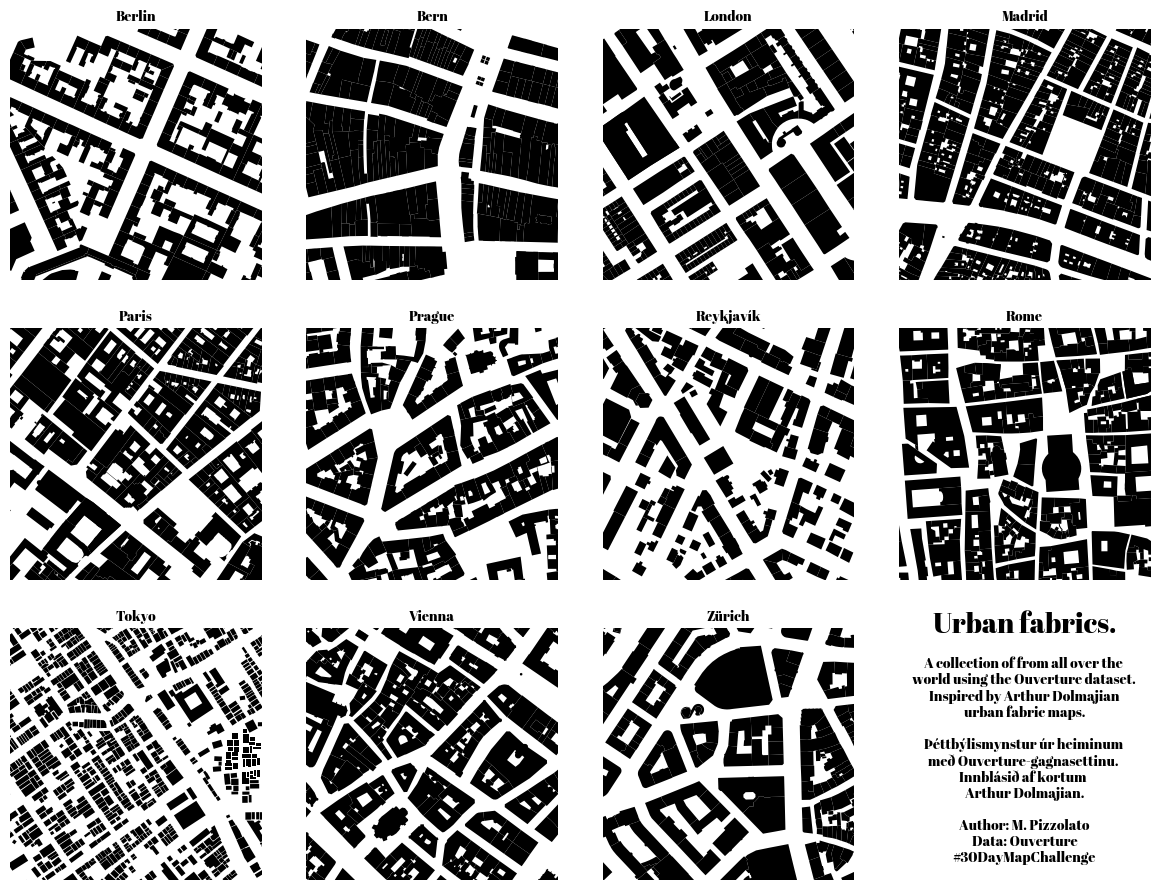

In [ ]:
from matplotlib import font_manager
# Get fonts
font = font_manager.FontProperties(fname=font_path)

# Determine grid layout (3 subplots per row, maximum 3 rows for 15 cities)
n_cities = len(city_geodfs)
n_cols = 4  # Number of columns per row
n_rows = math.ceil(n_cities / n_cols)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows))

# Flatten axes array for easy indexing
axes = axes.flatten()

# Plot each city's buildings with a fixed 300x300 meter axis extent
for idx, (city, gdf) in enumerate(city_geodfs.items()):
        # Rename city names if necessary
    if city == "Zurich":
        city = "Zürich"
    elif city == "Tokio":
        city = "Tokyo"
    elif city == "Reykjavik":
        city = "Reykjavík"

    # Plot all buildings
    gdf.plot(ax=axes[idx], color='black', edgecolor='none')
    
    # Calculate the center of the bounding box
    bounds = gdf.total_bounds  # minx, miny, maxx, maxy
    center_x = (bounds[0] + bounds[2]) / 2
    center_y = (bounds[1] + bounds[3]) / 2
    
    # Set limits for a 500x500 meter extent
    lim = 500
    axes[idx].set_xlim(center_x - lim/2, center_x + lim/2)
    axes[idx].set_ylim(center_y - lim/2, center_y + lim/2)
    
    # Add city name as title
    axes[idx].set_title(city, fontsize=20, fontproperties=font)
    axes[idx].set_axis_off()  # Remove axes for clean plot

# Remove unused axes (if any)
for ax in axes[len(city_geodfs):]:
    fig.delaxes(ax)

# Set white background
fig.patch.set_facecolor('white')

# Add custom text to the bottom-right corner
fig.text(
    0.87, 0.3,  # x and y position (relative to the figure, bottom-right corner)
    "Urban fabrics.",
    ha='center',  # Align text to the right
    va='center',  # Center vertically
    fontsize=20, 
    fontproperties=font
)

# Add custom text to the bottom-right corner
fig.text(
    0.87, 0.23,  # x and y position (relative to the figure, bottom-right corner)
    "A collection of from all over the \nworld using the Overture dataset.\nInspired by Arthur Dolmajian\nurban fabric maps.",
    ha='center',  # Align text to the right
    va='center',  # Center vertically
    fontsize=10, 
    fontproperties=font
)

# Add custom text to the bottom-right corner
fig.text(
    0.87, 0.14,  # x and y position (relative to the figure, bottom-right corner)
    "Þéttbýlismynstur úr heiminum \nmeð Overture-gagnasettinu. \nInnblásið af kortum \nArthur Dolmajian.",
    ha='center',  # Align text to the right
    va='center',  # Center vertically
    fontsize=10, 
    fontproperties=font
)

fig.text(
    0.87, 0.06,  # x and y position (relative to the figure, bottom-right corner)
    "Author: M. Pizzolato\nData: Overture\n#30DayMapChallenge",
    ha='center',  # Align text to the right
    va='center',  # Center vertically
    fontsize=10, 
    fontproperties=font
)

plt.tight_layout()
plt.show()

## Save

In [ ]:
# Save the figure with padding around it
fig.savefig("Day29-Overture.png", bbox_inches="tight", pad_inches=0.2, dpi=300)